In [7]:
import hydra
from glob import  glob
import numpy as np
import matplotlib.pyplot as plt
from omegaconf import OmegaConf

from proteoscope.data import ProteoscopeDM
from proteoscope.modules import CytoselfLM, AutoencoderLM, ProteoscopeLM


test = 'proteoscope' # proteoscope autoencoder

#BASE_DIR = f"/home/ec2-user/outputs/{test}/2023-08-19/04-21-57" #
BASE_DIR = f"/home/ec2-user/outputs/{test}/2023-08-19/00-13-08" #

config_dir = BASE_DIR + "/.hydra"

with hydra.initialize_config_dir(config_dir=config_dir):
    config = hydra.compose(config_name="config", overrides=OmegaConf.load(config_dir + "/overrides.yaml"))

    chkpts = glob(BASE_DIR + "/checkpoints/*.ckpt")
    chkpts.sort()
    chkpt = chkpts[-1]
    print('   Using ', chkpt)

    pdm = ProteoscopeDM(
        images_path=config.data.images_path,
        labels_path=config.data.labels_path,
        sequences_path=config.data.sequences_path,
        batch_size=config.trainer.batch_size,
        num_workers=config.trainer.num_workers,
        trim=config.data.trim,
        sequence_embedding=config.data.sequence_embedding
    )
    pdm.setup()

    if test == 'autoencoder':
        alm = AutoencoderLM.load_from_checkpoint(
            chkpt,
            module_config=config.module,
            strict=False,
        )

        alm.vae.to('cuda')
        alm.eval()
    elif test == 'proteoscope':
        plm = ProteoscopeLM.load_from_checkpoint(
            chkpt,
            module_config=config.module,
            strict=False,
        )

        plm.unet.eval()
        plm.unet.cuda()
        plm.autoencoder.cuda()
    else:
        raise ValueError(f"Unrecognized option {test}")

BASE_DIR = "/home/ec2-user/outputs/cytoself/2023-08-03/05-45-38" # 1 epoch epoch=6-step=69500
config_dir = BASE_DIR + "/.hydra"

with hydra.initialize_config_dir(config_dir=config_dir):
    config = hydra.compose(config_name="config", overrides=OmegaConf.load(config_dir + "/overrides.yaml"))

    chkpts = glob(BASE_DIR + "/checkpoints/*.ckpt")
    chkpts.sort()
    chkpt = chkpts[-1]
    print('   Using ', chkpt)

    clm = CytoselfLM.load_from_checkpoint(
        chkpt,
        module_config=config.module,
    )

    clm.model.to('cuda')
    clm.model.eval()

/tmp/ipykernel_12646/2610855286.py:18: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with hydra.initialize_config_dir(config_dir=config_dir):


   Using  /home/ec2-user/outputs/proteoscope/2023-08-19/00-13-08/checkpoints/last.ckpt


/home/ec2-user/proteoscope/proteoscope/data/datamodule.py:39: DtypeWarning: Columns (17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  self.labels = pd.read_csv(self.labels_path, index_col=0)
/tmp/ipykernel_12646/2610855286.py:62: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with hydra.initialize_config_dir(config_dir=config_dir):


   Using  /home/ec2-user/outputs/cytoself/2023-08-03/05-45-38/checkpoints/last.ckpt


Lightning automatically upgraded your loaded checkpoint from v1.9.4 to v2.0.6. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../outputs/cytoself/2023-08-03/05-45-38/checkpoints/last.ckpt`
/opt/conda/envs/pytorch/lib/python3.9/site-packages/torchvision/ops/misc.py:120: UserWarning: Don't use ConvNormActivation directly, please use Conv2dNormActivation and Conv3dNormActivation instead.
  warnings.warn(


## Reconstruct val images

In [71]:
import torch
from tqdm import tqdm
import numpy as np
from piqa import SSIM, PSNR
from torchmetrics.image.fid import FrechetInceptionDistance


ssim = SSIM(n_channels=1).to('cuda')
psnr = PSNR().to('cuda')
fid_pro = FrechetInceptionDistance(normalize=True).to('cuda')
fid_nuc = FrechetInceptionDistance(normalize=True).to('cuda')

index = []
input_images = []
output_images = []
input_cytoself_embeds = []
output_cytoself_embeds = []
input_autoencoder_embeds = []
input_cytoself_logits = []
output_cytoself_logits = []
diffused_autoencoder_embeds = []

ssim_scores_pro = []
ssim_scores_nuc = []
psnr_scores_pro = []
psnr_scores_nuc = []

dl = pdm.val_dataloader(novel_proteins=True, shuffle=True)

with torch.no_grad():
    for batch in tqdm(dl):
        batch['image'] = batch['image'].to('cuda')
        
        input_image = batch['image']
        input_cytoself_embed = clm.model(input_image, 'vqvec2')
        _, input_cytoself_logit = clm.model(input_image)

        if test == 'autoencoder':
            output_image, _, input_autoencoder_embed = alm(input_image, return_embed=True, sample_posterior=False)
            diffused_autoencoder_embed = torch.tensor.empty(0)
        elif test == 'proteoscope':
            diffused_autoencoder_embed = plm.sample(batch, guidance_scale=7, cond_images=None, num_inference_steps=300)
            output_image = plm.autoencoder.decode(diffused_autoencoder_embed).sample
            input_autoencoder_embed = plm.autoencoder.encode(batch['image']).latent_dist.mean

        output_image = output_image.clip(0, 1)
        output_cytoself_embed = clm.model(output_image, 'vqvec2')
        _, output_cytoself_logit = clm.model(output_image)

        ssim_pro = ssim(input_image[:, 0].unsqueeze_(1), torch.clip(output_image[:, 0].unsqueeze_(1), 0, 1))
        ssim_nuc = ssim(input_image[:, 1].unsqueeze_(1), torch.clip(output_image[:, 1].unsqueeze_(1), 0, 1))

        psnr_pro = psnr(input_image[:, 0].unsqueeze_(1), torch.clip(output_image[:, 0].unsqueeze_(1), 0, 1))
        psnr_nuc = psnr(input_image[:, 1].unsqueeze_(1), torch.clip(output_image[:, 1].unsqueeze_(1), 0, 1))

        fid_pro.update(input_image[:, 0].unsqueeze_(1).tile(1, 3, 1, 1), real=True)
        fid_pro.update(torch.clip(output_image[:, 0].unsqueeze_(1), 0, 1).tile(1, 3, 1, 1), real=False)

        fid_nuc.update(input_image[:, 1].unsqueeze_(1).tile(1, 3, 1, 1), real=True)
        fid_nuc.update(torch.clip(output_image[:, 1].unsqueeze_(1), 0, 1).tile(1, 3, 1, 1), real=False)

        index.append(batch['index'].detach().cpu().numpy())
        ssim_scores_pro.append([ssim_pro.detach().cpu().numpy()])
        ssim_scores_nuc.append([ssim_nuc.detach().cpu().numpy()])
        psnr_scores_pro.append([psnr_pro.detach().cpu().numpy()])
        psnr_scores_nuc.append([psnr_nuc.detach().cpu().numpy()])
        input_images.append(input_image.detach().cpu().numpy())
        output_images.append(output_image.detach().cpu().numpy())
        input_cytoself_embeds.append(input_cytoself_embed.detach().cpu().numpy())
        output_cytoself_embeds.append(output_cytoself_embed.detach().cpu().numpy())
        input_autoencoder_embeds.append(input_autoencoder_embed.detach().cpu().numpy())
        input_cytoself_logits.append(input_cytoself_logit.detach().cpu().numpy())
        output_cytoself_logits.append(output_cytoself_logit.detach().cpu().numpy())
        diffused_autoencoder_embeds.append(diffused_autoencoder_embed.detach().cpu().numpy())

  0%|          | 0/664 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 1/664 [00:23<4:18:52, 23.43s/it]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 2/664 [00:44<4:06:05, 22.30s/it]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 3/664 [01:06<4:01:48, 21.95s/it]

  0%|          | 0/300 [00:00<?, ?it/s]

  1%|          | 4/664 [01:28<3:59:42, 21.79s/it]

  0%|          | 0/300 [00:00<?, ?it/s]

  1%|          | 5/664 [01:49<3:58:23, 21.71s/it]

  0%|          | 0/300 [00:00<?, ?it/s]

  1%|          | 6/664 [02:11<3:57:30, 21.66s/it]

  0%|          | 0/300 [00:00<?, ?it/s]

  1%|          | 7/664 [02:32<3:56:47, 21.63s/it]

  0%|          | 0/300 [00:00<?, ?it/s]

  1%|          | 8/664 [02:54<3:56:14, 21.61s/it]

  0%|          | 0/300 [00:00<?, ?it/s]

  1%|▏         | 9/664 [03:15<3:55:50, 21.60s/it]

  0%|          | 0/300 [00:00<?, ?it/s]

  2%|▏         | 10/664 [03:37<3:55:28, 21.60s/it]

  0%|          | 0/300 [00:00<?, ?it/s]

  2%|▏         | 11/664 [03:59<3:55:06, 21.60s/it]

  0%|          | 0/300 [00:00<?, ?it/s]

  2%|▏         | 12/664 [04:20<3:54:46, 21.60s/it]

  0%|          | 0/300 [00:00<?, ?it/s]

  2%|▏         | 13/664 [04:42<3:54:53, 21.65s/it]

  0%|          | 0/300 [00:00<?, ?it/s]

  2%|▏         | 14/664 [05:04<3:55:10, 21.71s/it]

  0%|          | 0/300 [00:00<?, ?it/s]

  2%|▏         | 15/664 [05:26<3:55:16, 21.75s/it]

  0%|          | 0/300 [00:00<?, ?it/s]

  2%|▏         | 16/664 [05:47<3:55:14, 21.78s/it]

  0%|          | 0/300 [00:00<?, ?it/s]

  3%|▎         | 17/664 [06:09<3:55:10, 21.81s/it]

  0%|          | 0/300 [00:00<?, ?it/s]

  3%|▎         | 18/664 [06:31<3:55:00, 21.83s/it]

  0%|          | 0/300 [00:00<?, ?it/s]

  3%|▎         | 19/664 [06:53<3:54:46, 21.84s/it]

  0%|          | 0/300 [00:00<?, ?it/s]

  3%|▎         | 20/664 [07:15<3:54:32, 21.85s/it]

  0%|          | 0/300 [00:00<?, ?it/s]

  3%|▎         | 21/664 [07:37<3:54:13, 21.86s/it]

  0%|          | 0/300 [00:00<?, ?it/s]

  3%|▎         | 22/664 [07:59<3:53:54, 21.86s/it]

  0%|          | 0/300 [00:00<?, ?it/s]

  3%|▎         | 23/664 [08:21<3:53:34, 21.86s/it]

  0%|          | 0/300 [00:00<?, ?it/s]

  4%|▎         | 24/664 [08:42<3:53:10, 21.86s/it]

  0%|          | 0/300 [00:00<?, ?it/s]

  4%|▍         | 25/664 [09:04<3:52:50, 21.86s/it]

  0%|          | 0/300 [00:00<?, ?it/s]

  4%|▍         | 26/664 [09:26<3:52:29, 21.86s/it]

  0%|          | 0/300 [00:00<?, ?it/s]

  4%|▍         | 27/664 [09:48<3:52:06, 21.86s/it]

  0%|          | 0/300 [00:00<?, ?it/s]

  4%|▍         | 28/664 [10:10<3:51:44, 21.86s/it]

  0%|          | 0/300 [00:00<?, ?it/s]

  4%|▍         | 29/664 [10:32<3:51:32, 21.88s/it]

  0%|          | 0/300 [00:00<?, ?it/s]

  5%|▍         | 30/664 [10:54<3:51:08, 21.88s/it]

  0%|          | 0/300 [00:00<?, ?it/s]

  5%|▍         | 31/664 [11:16<3:50:45, 21.87s/it]

  0%|          | 0/300 [00:00<?, ?it/s]

  5%|▍         | 32/664 [11:37<3:50:22, 21.87s/it]

  0%|          | 0/300 [00:00<?, ?it/s]

  5%|▍         | 33/664 [11:59<3:49:58, 21.87s/it]

  0%|          | 0/300 [00:00<?, ?it/s]

  5%|▌         | 34/664 [12:21<3:49:33, 21.86s/it]

  0%|          | 0/300 [00:00<?, ?it/s]

  5%|▌         | 35/664 [12:43<3:49:12, 21.86s/it]

  0%|          | 0/300 [00:00<?, ?it/s]

  5%|▌         | 36/664 [13:05<3:48:49, 21.86s/it]

  0%|          | 0/300 [00:00<?, ?it/s]

  6%|▌         | 37/664 [13:27<3:48:27, 21.86s/it]

  0%|          | 0/300 [00:00<?, ?it/s]

  6%|▌         | 38/664 [13:49<3:48:06, 21.86s/it]

  0%|          | 0/300 [00:00<?, ?it/s]

  6%|▌         | 39/664 [14:10<3:47:45, 21.86s/it]

  0%|          | 0/300 [00:00<?, ?it/s]

  6%|▌         | 40/664 [14:32<3:47:23, 21.86s/it]

  0%|          | 0/300 [00:00<?, ?it/s]

  6%|▌         | 41/664 [14:54<3:47:08, 21.88s/it]

  0%|          | 0/300 [00:00<?, ?it/s]

  6%|▋         | 42/664 [15:16<3:48:05, 22.00s/it]

  0%|          | 0/300 [00:00<?, ?it/s]

  6%|▋         | 43/664 [15:38<3:47:21, 21.97s/it]

  0%|          | 0/300 [00:00<?, ?it/s]

  7%|▋         | 44/664 [16:00<3:46:43, 21.94s/it]

  0%|          | 0/300 [00:00<?, ?it/s]

  7%|▋         | 45/664 [16:22<3:46:09, 21.92s/it]

  0%|          | 0/300 [00:00<?, ?it/s]

  7%|▋         | 45/664 [16:26<3:46:15, 21.93s/it]


KeyboardInterrupt: 

In [72]:
fid_pro_score = fid_pro.compute()
fid_nuc_score = fid_nuc.compute()

In [73]:
index = np.concatenate(index, axis=0)
ssim_scores_pro = np.concatenate(ssim_scores_pro, axis=0)
ssim_scores_nuc = np.concatenate(ssim_scores_nuc, axis=0)
psnr_scores_pro = np.concatenate(psnr_scores_pro, axis=0)
psnr_scores_nuc = np.concatenate(psnr_scores_nuc, axis=0)

In [74]:
print(len(input_images))

45


In [75]:
input_images = np.concatenate(input_images, axis=0)
output_images = np.concatenate(output_images, axis=0)
input_cytoself_embeds = np.concatenate(input_cytoself_embeds, axis=0)
input_autoencoder_embeds = np.concatenate(input_autoencoder_embeds, axis=0)
diffused_autoencoder_embeds = np.concatenate(diffused_autoencoder_embeds, axis=0)

In [76]:
input_cytoself_logits = np.concatenate(input_cytoself_logits, axis=0)
output_cytoself_logits = np.concatenate(output_cytoself_logits, axis=0)
output_cytoself_embeds = np.concatenate(output_cytoself_embeds, axis=0)

In [77]:
true_names = np.array(pdm.labels['name'])[index]
true_localizations = np.array(pdm.labels['localization'])[index]
true_labels = np.array(pdm.labels['label'])[index]

In [78]:
print(input_autoencoder_embeds.max())
print(input_autoencoder_embeds.min())

7.6816144
-9.534569


In [79]:
print(fid_pro_score)
print(fid_nuc_score)

tensor(150.6755, device='cuda:0')
tensor(27.0310, device='cuda:0')


In [80]:
print(ssim_scores_pro.mean())
print(ssim_scores_nuc.mean())

0.3648975
0.8551095


In [81]:
print(psnr_scores_pro.mean())
print(psnr_scores_nuc.mean())

18.290125
30.23728


In [82]:
input_cytoself_labels = input_cytoself_logits.argmax(axis=1)
output_cytoself_labels = output_cytoself_logits.argmax(axis=1)

Accuracy 0.0


/tmp/ipykernel_12646/2643707609.py:12: RuntimeWarning: invalid value encountered in divide
  cm_norm = cm / cm.sum(axis=1)[:, None]
/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/matrix.py:198: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


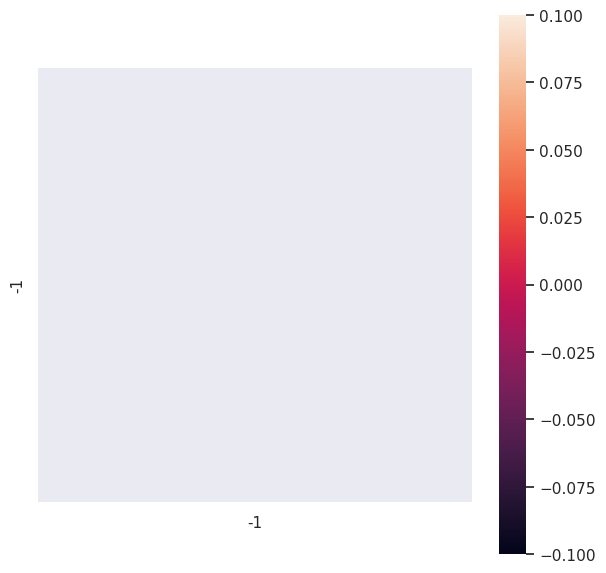

In [83]:
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

class_labels = np.unique(true_labels)

acc = accuracy_score(true_labels, input_cytoself_labels)
print(f'Accuracy {acc}')

cm = confusion_matrix(true_labels, input_cytoself_labels, labels=class_labels)
cm_norm = cm / cm.sum(axis=1)[:, None]
cm_df = pd.DataFrame(cm_norm, index=class_labels, columns=class_labels)

plt.figure(figsize=(7, 7))
sns.heatmap(cm_df, square=True, annot=False, fmt=".2f");

Accuracy 0.0


/tmp/ipykernel_12646/2910221747.py:5: RuntimeWarning: invalid value encountered in divide
  cm_norm = cm / cm.sum(axis=1)[:, None]
/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/matrix.py:198: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


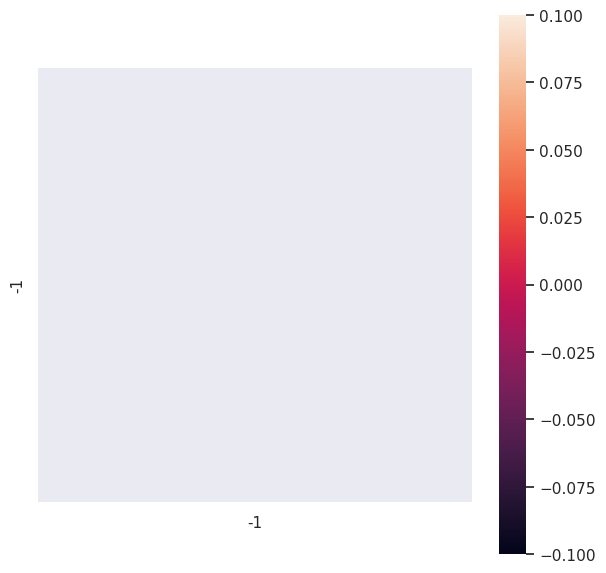

In [84]:
acc = accuracy_score(true_labels, output_cytoself_labels)
print(f'Accuracy {acc}')

cm = confusion_matrix(true_labels, output_cytoself_labels, labels=class_labels)
cm_norm = cm / cm.sum(axis=1)[:, None]
cm_df = pd.DataFrame(cm_norm, index=class_labels, columns=class_labels)

plt.figure(figsize=(7, 7))
sns.heatmap(cm_df, square=True, annot=False, fmt=".2f");

In [85]:
def top_k_accuracy(y_true, y_score, k=5):
    # Get the indices of the top k predicted classes for each sample
    top_k_preds = np.argsort(y_score, axis=1)[:, -k:]
    
    # Check if the true class is among the top k for each sample
    correct = np.any(top_k_preds == y_true[:, np.newaxis], axis=1)

    # Calculate the mean accuracy
    top_k_acc = np.mean(correct)
    
    return top_k_acc

In [86]:
input_classification_scores = [top_k_accuracy(true_labels, input_cytoself_logits, k=k) for k in range(1, 20)]

In [87]:
output_classification_scores = [top_k_accuracy(true_labels, output_cytoself_logits, k=k) for k in range(1, 20)]

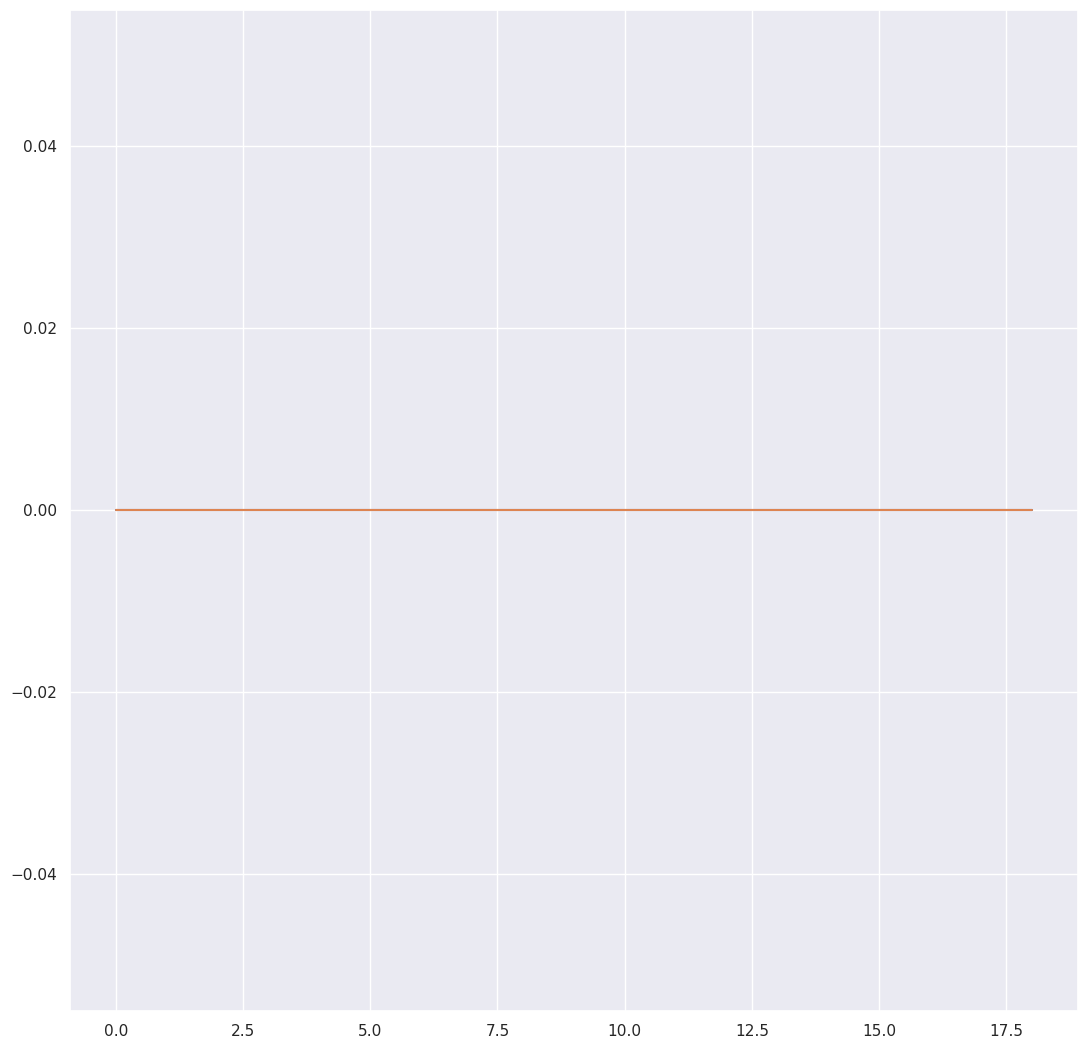

In [88]:
plt.plot(input_classification_scores);
plt.plot(output_classification_scores);

In [89]:
print(input_classification_scores[9])
print(output_classification_scores[9])

0.0
0.0


In [90]:
# FID ↓ IS ↑ PSNR ↑ SSIM ↑
# FCD, CS ....

In [91]:
from proteoscope.plotting import browse_reconstructions, merge_prot_nuc

In [92]:
browse_reconstructions(input_images[:, 0], output_images[:, 0], true_names)

interactive(children=(Dropdown(description='name', options=('AGAP1', 'AKAP13', 'AKT2', 'AMBRA1', 'ANAPC11', 'A…

## Merged nuclei view

In [93]:
true_merged = merge_prot_nuc(input_images[:1000], percentiles=[0.1, 99.9])
predicted_merged = merge_prot_nuc(output_images[:1000], percentiles=[0.1, 99.9])
true_names_merged = true_names[:1000]

In [94]:
browse_reconstructions(true_merged, predicted_merged, true_names_merged)

interactive(children=(Dropdown(description='name', options=('AGAP1', 'AKAP13', 'AKT2', 'AMBRA1', 'ANAPC11', 'A…

## Visualize in cytoself umap

In [95]:
import zarr
from os.path import join
import numpy as np

datapath = "/home/ec2-user/cytoself-data/results"

In [96]:
zarr_path = join(datapath, "cytoself_embeddings_vqvec2.zarr")

embeddings = np.asarray(zarr.open(zarr_path, mode='r'))
# localizations = np.load(join(datapath, "good_localizations_redo21.npy"))
# names = np.load(join(datapath, "good_names_redo21.npy"))
# complexes = np.load(join(datapath, "good_complexes_redo21.npy"))
# complexes_fig = np.load(join(datapath, "good_complexes_fig_redo21.npy"))


In [97]:
dl = pdm.val_dataloader(novel_proteins=False, shuffle=False)

names = np.array(dl.dataset.labels['name'])
localizations = np.array(dl.dataset.labels['localization'])
complexes = np.array(dl.dataset.labels['complex'])
complexes_fig = np.array(dl.dataset.labels['complex_fig'])

In [98]:
print(embeddings.max())
print(embeddings.min())

print(output_cytoself_embeds.max())
print(output_cytoself_embeds.min())

3.7375431060791016
-0.2739241123199463
3.737543
-0.2739241


In [99]:
from joblib import load

reducer = load(join(datapath,'cytoself_umap_model.joblib'))

In [100]:
reduced_embedding = reducer.transform(embeddings.reshape(embeddings.shape[0], -1))

In [101]:
reduced_input_cytoself_embeds = reducer.transform(input_cytoself_embeds.reshape(input_cytoself_embeds.shape[0], -1))
reduced_output_cytoself_embeds = reducer.transform(output_cytoself_embeds.reshape(output_cytoself_embeds.shape[0], -1))

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt

In [103]:
label_colors = {
    'other': [188, 188, 188],
    'mitochondria':  [135, 38, 35],
    'nucleoplasm':  [146, 210, 243],
    'ER':  [218, 56, 50],
    'cytoplasm':  [128, 189, 93],
    'vesicles':  [199, 175, 78],
    'nuclear_membrane':  [40, 63, 149],
    'nucleolus':  [93, 139, 198],
    'Golgi':  [216, 46, 138],
    'nuclear_domains':  [64, 144, 147],
}
for key, values in label_colors.items():
    label_colors[key] = np.array(values) / 255

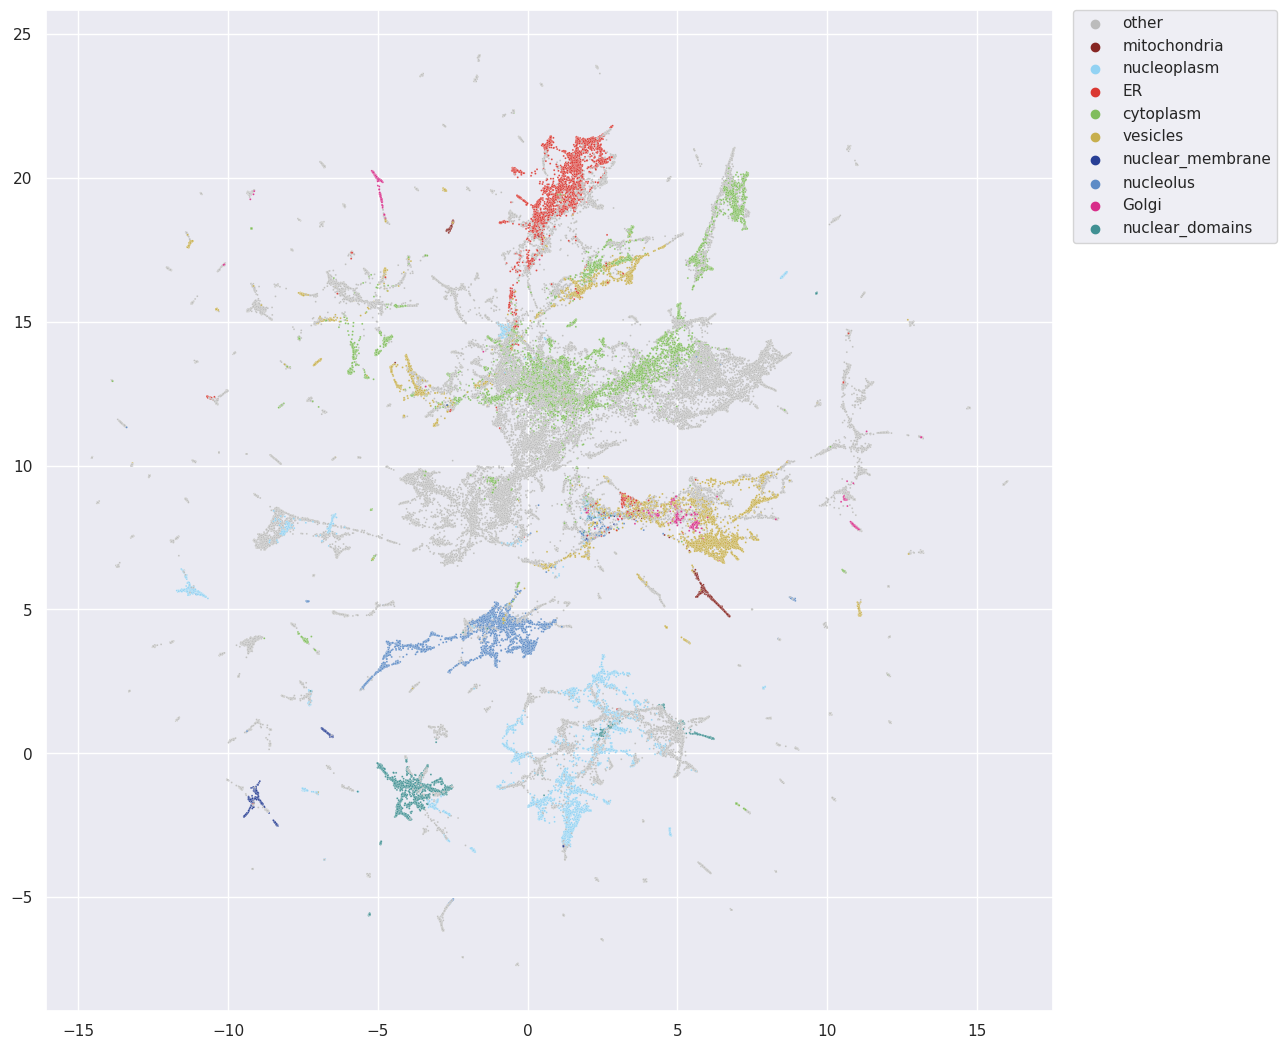

In [104]:
sns.set(rc={"figure.figsize":(13, 13)})
sns.scatterplot(x=reduced_embedding[:, 0], y=reduced_embedding[:, 1], hue=localizations, s=2, alpha=0.9, palette=label_colors)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);

<AxesSubplot:>

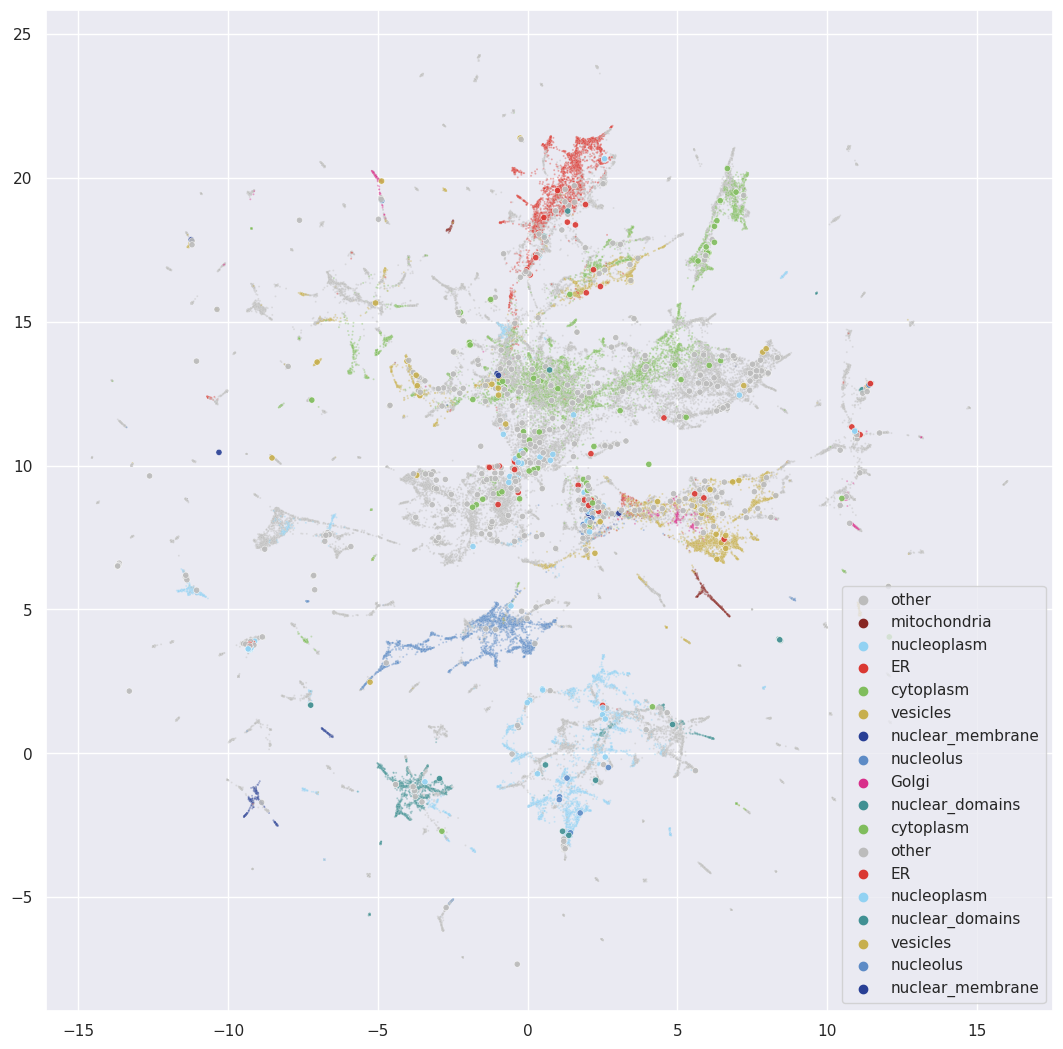

In [105]:
sns.set(rc={"figure.figsize":(13, 13)})
sns.scatterplot(x=reduced_embedding[:, 0], y=reduced_embedding[:, 1], hue=localizations, s=2, alpha=0.4, palette=label_colors)
sns.scatterplot(x=reduced_output_cytoself_embeds[:, 0], y=reduced_output_cytoself_embeds[:, 1], hue=true_localizations, s=20, alpha=0.9, palette=label_colors)

<AxesSubplot:>

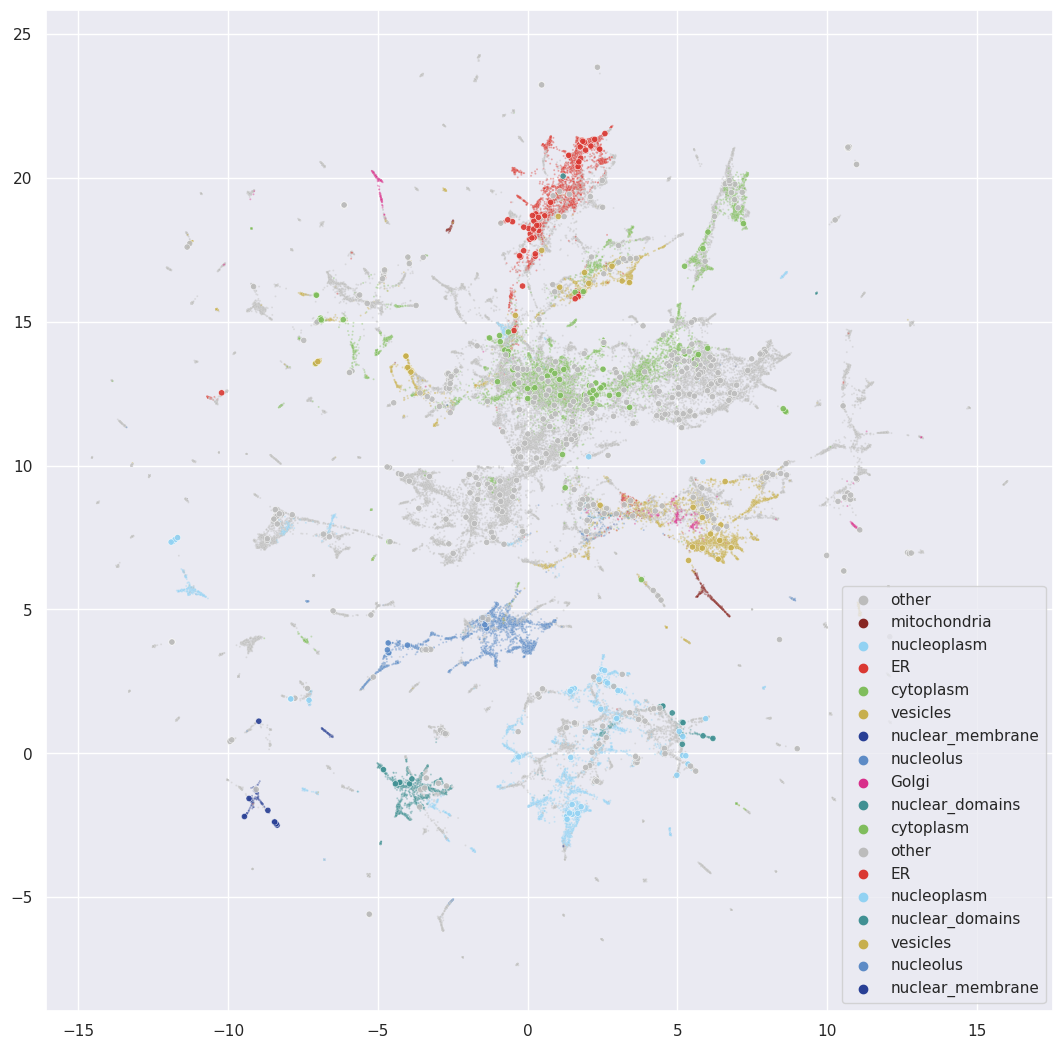

In [106]:
sns.set(rc={"figure.figsize":(13, 13)})
sns.scatterplot(x=reduced_embedding[:, 0], y=reduced_embedding[:, 1], hue=localizations, s=2, alpha=0.4, palette=label_colors)
sns.scatterplot(x=reduced_input_cytoself_embeds[:, 0], y=reduced_input_cytoself_embeds[:, 1], hue=true_localizations, s=20, alpha=0.9, palette=label_colors)

## FCD scores with cyostelf

In [107]:
def compute_latent_statistics(latents, classes=None, all_classes=None):
    latents = latents.reshape(latents.shape[0], -1)

    if classes is None:
        latent_mean = np.mean(latents, axis=0)
        latent_cov = np.cov(latents, rowvar=False)
    else:
        if all_classes is None:
            all_classes = np.unique(classes)

        latent_mean = np.array([np.mean(latents[classes == c], axis=0) for c in all_classes])
        latent_cov = np.array([np.cov(latents[classes == c], rowvar=False) for c in all_classes])

    return {'mean': latent_mean, 'cov': latent_cov, 'class': all_classes}

In [108]:
from scipy.linalg import sqrtm


def frechet_distance(mu1, sigma1, mu2, sigma2):
    """
    Compute the Fréchet distance between two multivariate Gaussian distributions.
    """
    mean_diff = mu1 - mu2
    mean_diff_squared = mean_diff.dot(mean_diff)
    cov_mean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(cov_mean):
        cov_mean = cov_mean.real
    trace_term = np.trace(sigma1 + sigma2 - 2 * cov_mean)
    frechet_dist = mean_diff_squared + trace_term
    return frechet_dist

In [109]:
all_names = np.unique(true_names)
input_cytoself_stats = compute_latent_statistics(input_cytoself_embeds, true_names, all_names)
output_cytoself_stats = compute_latent_statistics(output_cytoself_embeds, true_names, all_names)

/tmp/ipykernel_12646/3089917380.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  latent_cov = np.array([np.cov(latents[classes == c], rowvar=False) for c in all_classes])


In [110]:
# zipped = zip(input_cytoself_stats['mean'], input_cytoself_stats['cov'], output_cytoself_stats['mean'], output_cytoself_stats['cov'])
# fcd_scores = np.array([frechet_distance(mu1, sigma1, mu2, sigma2) for mu1, sigma1, mu2, sigma2 in zipped])

In [111]:
# print(fcd_scores.mean())
# print(fcd_scores.std())

In [112]:
input_cytoself_stats_all = compute_latent_statistics(input_cytoself_embeds, None, None)
output_cytoself_stats_all = compute_latent_statistics(output_cytoself_embeds, None, None)

In [113]:
mu1, sigma1 = input_cytoself_stats_all['mean'], input_cytoself_stats_all['cov']
mu2, sigma2 = output_cytoself_stats_all['mean'], output_cytoself_stats_all['cov']
fcd_score_all = frechet_distance(mu1, sigma1, mu2, sigma2)
print(fcd_score_all)

25.791611211384094


## Medians

In [114]:
import numpy as np
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

# Generate sample data
n = input_cytoself_stats['mean'].shape[0]
Set_A = input_cytoself_stats['mean'].copy()
Set_B = output_cytoself_stats['mean'].copy()

# Compute pairwise distances for given pairs
given_pair_dists = np.array([euclidean(Set_A[i], Set_B[i]) for i in range(n)])

# Compute pairwise distances for random pairs (1000 times)
random_pair_dists = []
np.random.seed(0)
for _ in range(1000):
    np.random.shuffle(Set_B)
    random_pair_dists.extend([euclidean(Set_A[i], Set_B[i]) for i in range(n)])

# Statistical comparison
_, p_value = mannwhitneyu(given_pair_dists, random_pair_dists)
print(f"P-value: {p_value}")

P-value: 0.016792478400186592


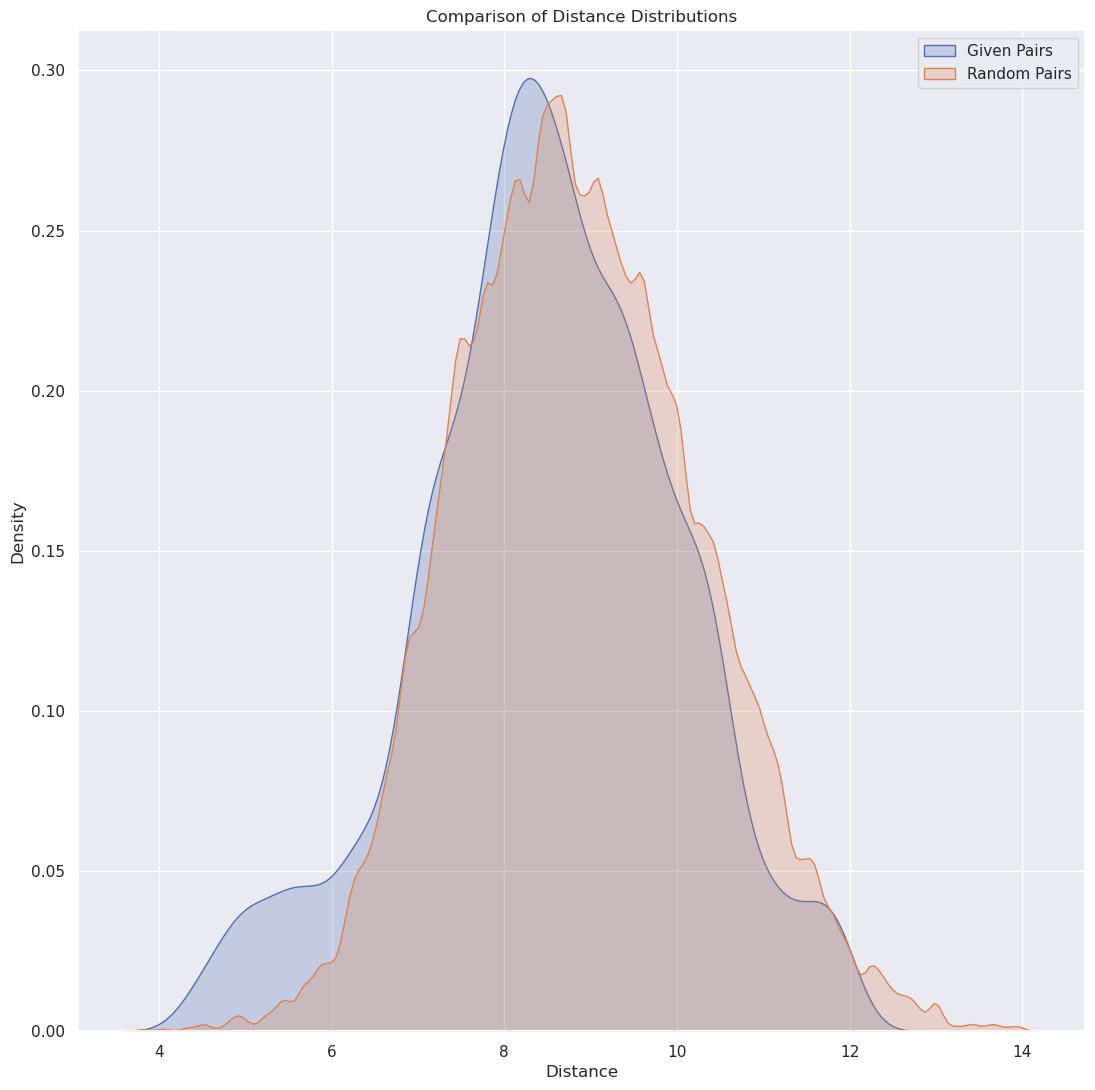

In [115]:
# Visualization
sns.kdeplot(given_pair_dists, label="Given Pairs", shade=True, clip=(0, None), bw_adjust=0.5)
sns.kdeplot(random_pair_dists, label="Random Pairs", shade=True, clip=(0, None), bw_adjust=0.5)
plt.legend()
plt.xlabel("Distance")
plt.ylabel("Density")
plt.title("Comparison of Distance Distributions")
plt.show()

In [116]:
print(np.mean(given_pair_dists))
print(np.mean(random_pair_dists))

8.500345026799875
8.867886864203815


## Run localization classifier

In [117]:
from joblib import load

# Load the model from the file
clf = load(join(datapath,'cytoself_localization_classifier.joblib'))

In [118]:
other = true_localizations == 'other'
X_test = input_cytoself_embeds[~other]
X_test = X_test.reshape((X_test.shape[0], -1))
y_test = true_localizations[~other]

In [119]:
y_predict = clf.predict(X_test)

In [120]:
y_predict_scores = clf.predict_proba(X_test)

In [121]:
y_test_indices = np.searchsorted(clf.classes_, y_test)
input_localization_classification_scores = [top_k_accuracy(y_test_indices, y_predict_scores, k=k) for k in range(1, 5)]

In [122]:
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd

class_labels = np.unique(y_test)

acc = accuracy_score(y_test, y_predict)
print(f'Accuracy {acc}')

cm = confusion_matrix(y_test, y_predict, labels=class_labels)
cm_norm = cm / cm.sum(axis=1)[:, None]
cm_df = pd.DataFrame(cm_norm, index=class_labels, columns=class_labels)


Accuracy 0.9156626506024096


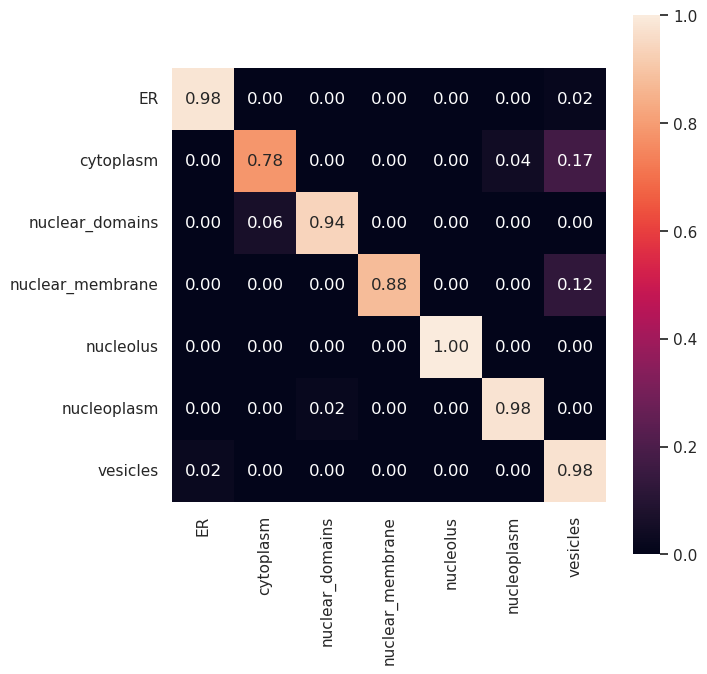

In [123]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
sns.heatmap(cm_df, square=True, annot=True, fmt=".2f");


In [124]:
other = true_localizations == 'other'
X_test = output_cytoself_embeds[~other]
X_test = X_test.reshape((X_test.shape[0], -1))
y_test = true_localizations[~other]

In [125]:
y_predict = clf.predict(X_test)

In [126]:
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd

class_labels = np.unique(y_test)

acc = accuracy_score(y_test, y_predict)
print(f'Accuracy {acc}')

cm = confusion_matrix(y_test, y_predict, labels=class_labels)
cm_norm = cm / cm.sum(axis=1)[:, None]
cm_df = pd.DataFrame(cm_norm, index=class_labels, columns=class_labels)


Accuracy 0.4497991967871486


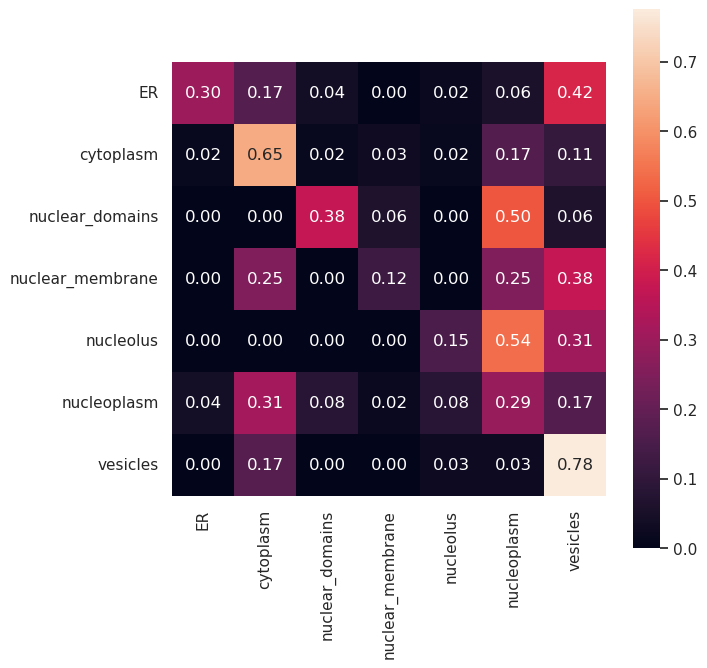

In [127]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
sns.heatmap(cm_df, square=True, annot=True, fmt=".2f");


In [128]:
y_predict_scores = clf.predict_proba(X_test)

In [129]:
output_localization_classification_scores = [top_k_accuracy(y_test_indices, y_predict_scores, k=k) for k in range(1, 5)]

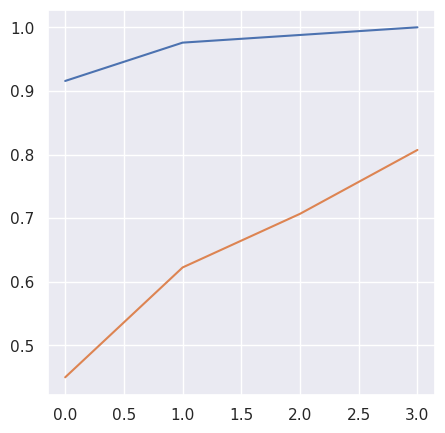

In [130]:
plt.figure(figsize=(5, 5))
plt.plot(input_localization_classification_scores);
plt.plot(output_localization_classification_scores);

In [131]:
print(input_localization_classification_scores[2])
print(output_localization_classification_scores[2])

0.9879518072289156
0.7068273092369478


## Autoencoder

In [93]:
import umap


n_neighbors = 15
min_dist = 0.1
metric = 'euclidean'
reducer_autoencoder = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, metric=metric)
reducer_autoencoder.fit(input_autoencoder_embeds.reshape(input_autoencoder_embeds.shape[0], -1))

UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [94]:
from joblib import dump
from joblib import load

dump(reducer_autoencoder, join(datapath,'autoencoder_umap_model.joblib'))

# reducer = load(join(datapath,'autoencoder_umap_model.joblib'))

['/home/ec2-user/cytoself-data/results/autoencoder_umap_model.joblib']

In [95]:
reduced_autoencoder_latent = reducer_autoencoder.transform(input_autoencoder_embeds.reshape(input_autoencoder_embeds.shape[0], -1))

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt

In [97]:
label_colors = {
    'other': [188, 188, 188],
    'mitochondria':  [135, 38, 35],
    'nucleoplasm':  [146, 210, 243],
    'ER':  [218, 56, 50],
    'cytoplasm':  [128, 189, 93],
    'vesicles':  [199, 175, 78],
    'nuclear_membrane':  [40, 63, 149],
    'nucleolus':  [93, 139, 198],
    'Golgi':  [216, 46, 138],
    'nuclear_domains':  [64, 144, 147],
}
for key, values in label_colors.items():
    label_colors[key] = np.array(values) / 255

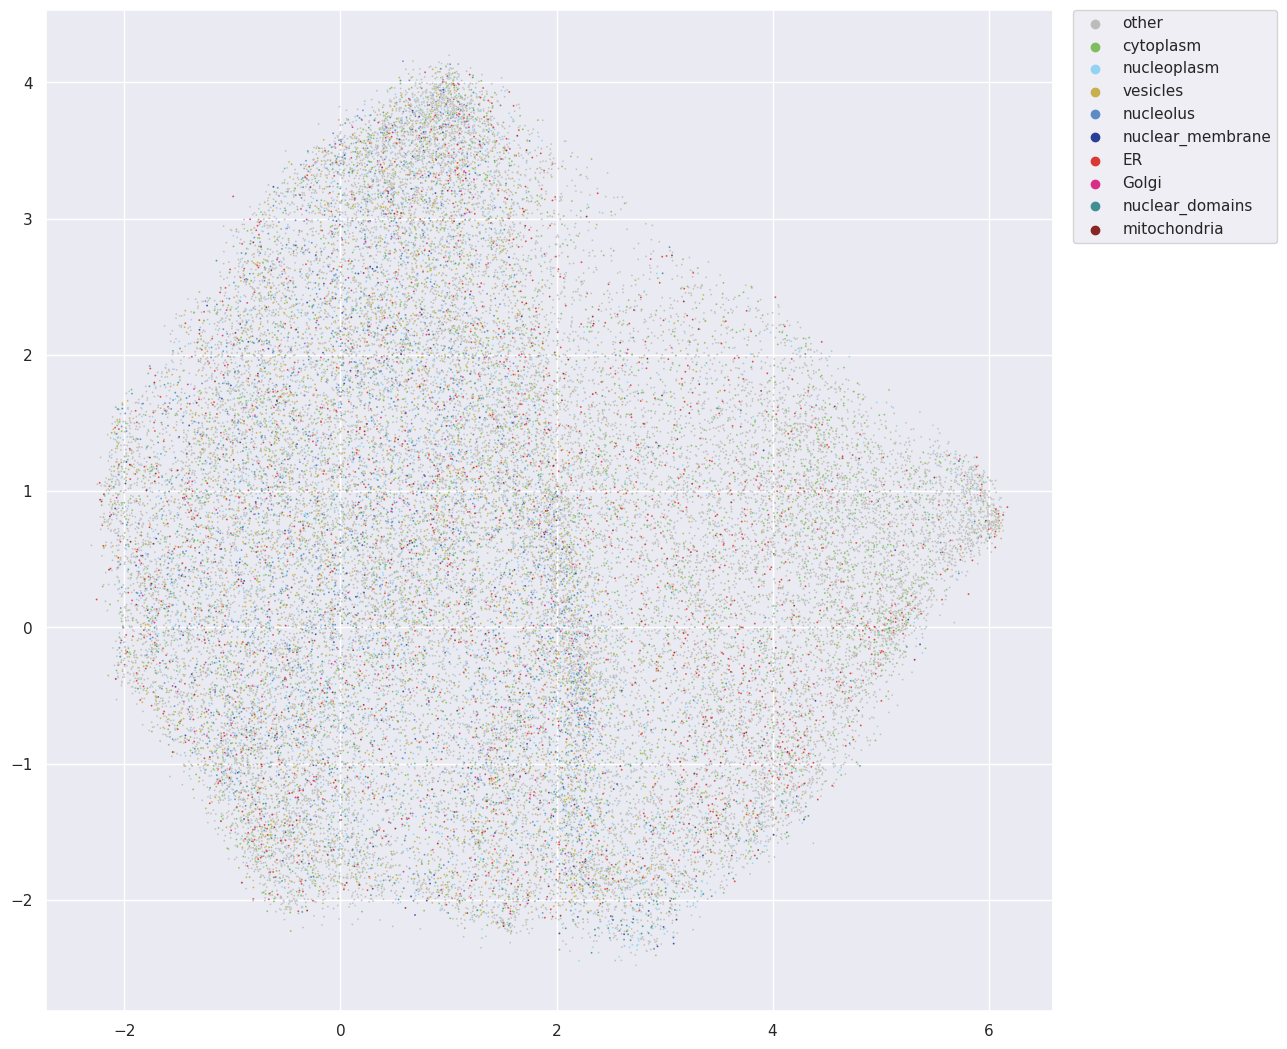

In [98]:
sns.set(rc={"figure.figsize":(13, 13)})
sns.scatterplot(x=reduced_autoencoder_latent[:, 0], y=reduced_autoencoder_latent[:, 1], hue=true_localizations, s=2, alpha=0.9, palette=label_colors)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);